# Principal Components Analysis on the Olivetti faces dataset

[Principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables. 
Precisely, we look for $k \leq n$ [orthogonal](https://en.wikipedia.org/wiki/Orthogonality) vectors $u^{(1)}, u^{(2)}, \ldots, u^{(k)}$, called __principal components__, that minimize the projection error of the example features on the linear subspace they [span](https://en.wikipedia.org/wiki/Linear_span).
As a result of this construction the greatest variance of the data lies progressively on the different axes individuated by the principal components.
Usually, we choose the number of principal components $k$ to be the smallest to retain a certain value of variance, usually between 0.9 and 0.99.

PCA is mainly used as a tool in exploratory data analysis and to support the building of predictive models, but it can be used also to speed up supervised machine learning algorithms.

It is usually done by eigenvalue decomposition of the [correlation matrix](https://www.wikiwand.com/en/Covariance_matrix#/Correlation_matrix) or by singular value decomposition of the data matrix, usually after some preprocessing. Note that we won't implement directly the algorithm, as we are primarily interested in showing its application in a common scenario, but we'll delegate it to the [scikit-learn](http://scikit-learn.org/) library.

## Implementation

### Import

Let's import the Olivetti faces dataset from the scikit-learn [built-in datasets](http://scikit-learn.org/stable/datasets/index.html#the-olivetti-faces-dataset):

In [133]:
from sklearn.datasets import fetch_olivetti_faces
dataset = fetch_olivetti_faces(data_home='/tmp/data/', shuffle=False)

n_samples, width, height = dataset.images.shape

print("Dataset consists of {n} {w}x{h} faces".format(n=n_samples, w=width, h=height))

Dataset consists of 400 64x64 faces


In [134]:
dataset.keys()

dict_keys(['DESCR', 'data', 'target', 'images'])

In [135]:
print(dataset.DESCR)

Modified Olivetti faces dataset.

The original database was available from

    http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

The version retrieved here comes in MATLAB format from the personal
web page of Sam Roweis:

    http://www.cs.nyu.edu/~roweis/

There are ten different images of each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open / closed eyes, smiling / not smiling) and facial
details (glasses / no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

The original dataset consisted of 92 x 112, while the Roweis version
consists of 64x64 images.



As told in the description, the dataset consists of ten 64x64 face images of 40 different subjects, for a total of 400 pictures.

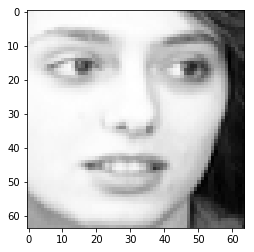

In [136]:
import matplotlib.pyplot as plt
%matplotlib inline

faces = dataset.data

plt.imshow((-1)*faces[79].reshape((64,64)),cmap='Greys')

To visualize more than one face at a time, we build a simple function to represent the faces in a grid:

In [137]:
import numpy as np
import matplotlib.pyplot as plt

def displayData(data, *width):
    '''
    Display data in a 2-dimensional grid
    '''

    # Set ex_width
    if width:
        ex_width = width[0]
    else:
        ex_width = int(np.sqrt(np.shape(data)[1]));

    # Compute dimensions
    (n_examples, n) = np.shape(data);
    ex_height = int(n / ex_width);
    n_rows = int(np.floor(np.sqrt(n_examples)));
    n_cols = int(np.ceil(n_examples / n_rows));

    # Set padding
    pad = 1;

    # Core
    grid = np.zeros( (pad + n_rows * (ex_height + pad),
                                pad + n_cols * (ex_width + pad)) );    
    cur = 0; # current example
    for j in range(0, n_rows):
        if cur >= n_examples: break;
        for i in range(0, n_cols):
            if cur >= n_examples: break;
            max_val = np.max(np.abs(data[cur, :]));
            from_row = pad + j * (ex_height + pad); to_row = from_row + ex_height;
            from_col = pad + i * (ex_width + pad); to_col = from_col + ex_width;
            grid[from_row:to_row,from_col:to_col] = \
                data[cur, :].reshape( (ex_height, ex_width) ) / max_val;
            cur += 1;
        

    # Display data
    if(n_examples<100):
        fig = plt.figure();
    else:
        fig = plt.figure(figsize=(n_examples/10,n_examples/20));
    ax = fig.add_axes([0, 0, 1, 1]);
    ax.imshow((-1)*grid, extent=[0, 1, 0, 1], cmap='Greys');

    plt.show();

    print('examples: ',n_examples);
    print('n_rows: ', n_rows);
    print('n_cols: ', n_cols);
    print('example width: ', ex_width);
    print('example height:', ex_height);


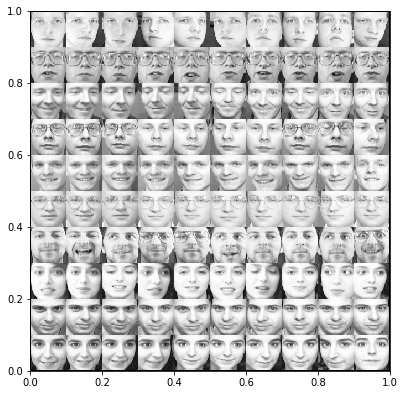

examples:  100
n_rows:  10
n_cols:  10
example width:  64
example height: 64


In [138]:
displayData(faces[:100],width)

### Pre-processing

When applying PCA, it's usually a good practice to make some data preprocessing, specifically feature scaling and normalizing. This is reasonable, as PCA deals with the variance of different features, which may differ significantly. In `scikit-learn` we make use of the `preprocessing` library to actually realize feature scaling and normalizing and the `pipeline` library to concatenate these actions in a process flow:

In [139]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline

preprocessing = Pipeline([
    ('scaler', StandardScaler()),   # StandardScaler must be first
    ('normalizer', Normalizer()),
])

preprocessing.fit(faces)
X = preprocessing.transform(faces)

In [140]:
print('Means: ', X.mean(axis=0)[0:5]) # should be 0
print('Standard deviations: ', X.std(axis=0)[0:5]) # should be 1
print('Norms: ', np.sqrt(np.sum(X**2, axis=1))[0:5]) # should be 1

Means:  [ 0.000799    0.00086887  0.00081703  0.0007419   0.00072766]
Standard deviations:  [ 0.01655554  0.01624939  0.01612844  0.01593213  0.01552488]
Norms:  [ 0.99999988  0.99999976  0.99999976  1.00000012  0.99999976]


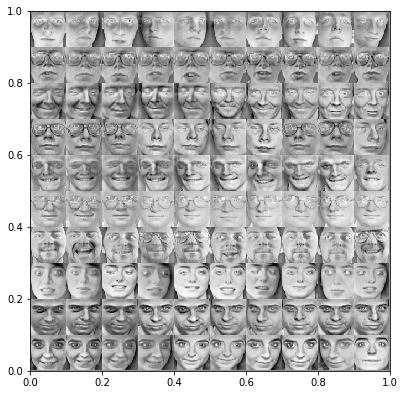

examples:  100
n_rows:  10
n_cols:  10
example width:  64
example height: 64


In [141]:
displayData(X[:100,:],64)

### Fitting

At this point we do PCA using `scikit-learn` `decomposition` library, assigning temporarily the number of components to 24 to better understand and visualize the concepts:

In [147]:
from sklearn.decomposition import PCA
pca = PCA(n_components=24)

pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In `scikit-learn` PCA algorithm, the $k$ vectors which minimize the projection error are the first $k$ vectors $u^{(1)}, u^{(2)}, \ldots, u^{(k)}$
of the matrix $U$ obtained from the [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) of the matrix $\Sigma = \frac{1}{m} \sum_{i=1}^n (x_i)(x_i)^T$. 

> Singular value decomposition is a factorization of the form $M = U \varSigma V^∗$, where $M$ is the $m \times n$ real or complex matrix to be decomposed, $U$ an $m \times m$ real or complex unitary matrix, $\varSigma$ an $m \times n$ rectangular diagonal matrix with non-negative real numbers on the diagonal, and $V$ an $n \times n$ real or complex unitary matrix. The diagonal entries $\sigma_i$ of $\varSigma$ are known as the __singular values__ of $X$. The columns of $U$ are called __left-singular vectors__, while the columns of $V$ are called __right-singular vectors__.

In [148]:
U = pca.components_
U.shape

(24, 4096)

These vectors are [linear combinations](https://en.wikipedia.org/wiki/Linear_combination) of the [standard basis](https://en.wikipedia.org/wiki/Standard_basis) vectors and can be visualized as images, representing the coefficients as different gray intensities:

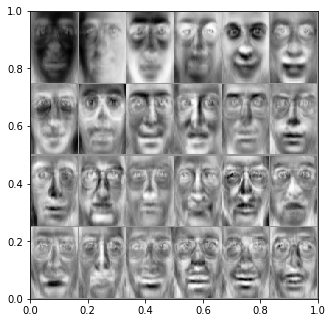

examples:  24
n_rows:  4
n_cols:  6
example width:  64
example height: 64


In [149]:
displayData(U, width)

The projected (compressed) features are then given by:




In [144]:
Z = pca.transform(X)


While the reconstructed features from compressed representation $x_\text{approx} = U \,z $ are given by:


In [145]:
X_recover = pca.inverse_transform(Z)

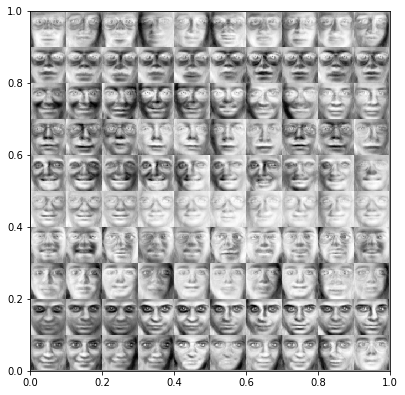

examples:  100
n_rows:  10
n_cols:  10
example width:  64
example height: 64


In [146]:
displayData(X_recover[:100,:])

We can observe that with just 24 components, the faces are still recognizable, but to have a more rigorous method to evaluate our model, we consider the explained variance as a metric:

In [104]:
sum(pca.explained_variance_)

0.77149072661995888

We observe that the explained variance is pretty low, as we usually want to retain at least the 99% of the data variance. To get the desired variance explanation, we proceed manually by testing crescent values of the `n_components` parameter:

In [132]:
pca = PCA(n_components=50).fit(X)
print(sum(pca.explained_variance_))
pca = PCA(n_components=100).fit(X)
print(sum(pca.explained_variance_))
pca = PCA(n_components=200).fit(X)
print(sum(pca.explained_variance_))
pca = PCA(n_components=250).fit(X)
print(sum(pca.explained_variance_))
pca = PCA(n_components=260).fit(X)
print(sum(pca.explained_variance_))

0.863503930392
0.930885792535
0.978202280239
0.988678806883
0.990210108983


In conclusion, with around 260 (of 4096) principal components the 99% of the variance in the data is retained. 

In this, like in most real life scenarios, it's possible to highly compress data and still retain most of the variance.
If we are not appying PCA as a preliminar step in a supervised machine learning problem, but we are in a more traditional analytical setting, the challenge at this point is in interpreting these vectors in order to get some insights on the data.